# Эвристика для поиска ROI

Вместо того, чтобы применять классификатор "наобум", можно для начала выбрать те области изображения, в которых вероятность нахождения объекта наиболее высока, и запускать классификатор лишь для них.

<center><img src ="https://ml.gan4x4.ru/msu/additions/L11/heuristics_way_object_detection_multiple_object.png" width="700"></center>

<center><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Detection and Segmentation</a></em></center>

Такие области называются **regions of interest**, сокращённо — **ROI**.

Для их поиска можно использовать какой-либо эвристический алгоритм, например [Selective search](https://ivi.fnwi.uva.nl/isis/publications/bibtexbrowser.php?key=UijlingsIJCV2013&bib=all.bib).

## Selective search

Selective search — известный алгоритмический метод поиска **ROI**.

Идея алгоритма состоит в разбиении изображения на небольшие области и последующем их итеративном объединении.

Объединение происходит на основании сходства, которое вычисляется как сумма 4-х метрик (см. иллюстрацию)

<center><img src ="https://ml.gan4x4.ru/msu/additions/L11/selective_search.png" width="800"></center>

<center><em>Source: <a href="http://www.huppelen.nl/publications/selectiveSearchDraft.pdf"> Selective Search for Object Recognition</a></em></center>


Возвращает порядка 2000 прямоугольников для изображения, отрабатывает за несколько секунд на CPU.

# R-CNN (Region CNN)



Первая известная модель, построенная по описанному принципу:

- на изображении ищутся ROI,
- для каждого делается resize,
- каждый ROI обрабатывается сверточной сетью, которая предсказывает класс объекта, который в него попал.

<center><img src ="https://ml.gan4x4.ru/msu/additions/L11/region_of_interest_cnn.png" width="700"></center>

<center><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Detection and Segmentation</a></em></center>

Кроме класса модель предсказывает смещения для каждого bounding box:

<center><img src ="https://ml.gan4x4.ru/msu/additions/L11/r_cnn_predict_bounded_box_shift.png" width="700"></center>

<center><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Detection and Segmentation</a></em></center>

# NMS

Теперь возникает другая проблема: в районе объекта алгоритм генерирует множество ограничивающих прямоугольников (bounding box), которые частично перекрывают друг друга.

<img src ="https://ml.gan4x4.ru/msu/additions/L11/non_max_suppression.png" width="650">

Чтобы избавиться от них, используется алгоритм
NMS (Non-maximum suppression). Его задача — избавиться от bounding boxes, которые накладаваются на истинный:

<center><img src ="https://ml.gan4x4.ru/msu/additions/L11/non_max_suppression_pseudo_code.png" width="1000"></center>

<center><em>Source: <a href="https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c"> Non-maximum Suppression (NMS)</a></em></center>

Здесь $B$ — это массив всех bounding boxes, $C$ — массив предсказаний модели относительно наличия объекта в соответствующем bounding box.



Для оценки схожести обычно используется метрика $\text{IoU}$ ($\text{same} == \text{IoU}$), а значение $\text{IoU}$ ($\lambda_{nms}$), при котором bounding boxes считаются принадлежащими одному объекту, является гиперпараметром (часто $0.5$).

В PyTorch алгоритм $\text{NMS}$ доступен в модуле `torchvision.ops`.

`torchvision.ops.nms(boxes, scores, iou_threshold)`,
где:
* `boxes` — массив bounding box,
* `scores` — предсказанная оценка,
* `iou_threshold` — порог $\text{IoU}$, $\text{NMS}$ отбрасывает все перекрывающиеся поля с $\text{IoU} > \text{iou_threshold}$

[[doc] torchvision.ops.nms](https://pytorch.org/vision/stable/generated/torchvision.ops.nms.html)

[Soft NMS](https://github.com/Gan4x4/ml_snippets/blob/main/CV/SoftNMS.ipynb)

# Fast R-CNN




Проблемой R-CNN являлась скорость, так как мы вынуждены применять CNN порядка 2000 раз (в зависимости от эвристики, которая генерирует ROI).

<center><img src ="https://ml.gan4x4.ru/msu/additions/L11/r_cnn_scheme.png" width="800"></center>

<center><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Detection and Segmentation</a></em></center>

И решением, которое предложили авторы Fast R-CNN, является поиск ROI не на самом изображении, а на карте признаков. В таком случае большая часть сверток выполняется только один раз.

<center><img src ="https://ml.gan4x4.ru/msu/additions/L11/fast_r_cnn_scheme.png" width="700"></center>

<center><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Detection and Segmentation</a></em></center>

Это значительно ускоряет процесс.

# ROI Pooling

Теперь появляется новая задача — получить карты признаков одинакового размера для всех ROI.

Для этого границы ROI проецируются на карту признаков.

Затем к полученным фрагментам карты признаков применяется операция max pooling, и выходы получаются фиксированного размера. Теперь их можно подать на вход полносвязного слоя.

<img src ="https://ml.gan4x4.ru/msu/additions/L11/roi_pooling.png" width="650">

ROI pooling в PyTorch


```
torchvision.ops.roi_pool(input, boxes, output_size,...)
```
где:
* `input` —  тензор с входными картами признаков,
* `boxes` —  массив bounding box,
* `output_size` — размер вывода после ROI pooling.


[Документация ROI Pooling](https://pytorch.org/vision/stable/generated/torchvision.ops.roi_pool.html)

Статья: [Region of Interest Pooling](https://towardsdatascience.com/region-of-interest-pooling-f7c637f409af)


# ROI Align


Операция ROI Pooling применялась в оригинальной модели Fast-RCNN. В дальнейшем она была заменена на ROI Align. Здесь признаки не отбрасываются, как это происходит при  max pooling, а их значения интерполируются на новую карту признаков.

<img src ="https://ml.gan4x4.ru/msu/additions/L11/roi_align.png" width="750">

Чтобы избежать квантования границ, RoIAlign использует билинейную интерполяцию для вычисления  значений входных признаков.

```
torchvision.ops.roi_align(input, boxes, output_size, ...)
```
где:
* `input` —  тензор с входными картами признаков,
* `boxes` —  массив bounding box,
* `output_size` — размер вывода после ROI Align.

[[doc] `torchvision.ops.roi_align`](https://pytorch.org/vision/stable/generated/torchvision.ops.roi_align.html)

[Understanding Region of Interest](https://towardsdatascience.com/understanding-region-of-interest-part-2-roi-align-and-roi-warp-f795196fc193)

# Faster R-CNN

**Идея: пусть сеть сама предсказывает ROI по карте признаков**

После того, как в Fast-RCNN большая часть сверток стала запускаться единожды,
скорость работы нейросетевой части существенно возросла.


<center><img src ="https://ml.gan4x4.ru/msu/additions/L11/compare_training_time_r_cnn_and_fast_r_cnn.png" width="900"></center>

<center><p><em>Source: <a href="https://aman.ai/cs231n/detection/">Detection and Segmentation</a></p> </em></center>

Теперь "узким местом" стала эвристика для поиска ROI.

Поэтому в следующей версии детектора (Faster R-CNN) от эвристики решено было избавиться, а  ROI искать при помощи дополнительной нейросети Region Proposal Network (RPN).




<center><img src ="https://ml.gan4x4.ru/msu/additions/L11/faster_r_cnn_scheme.png" width="650"></center>

<center><p><em>Source: <a href="https://tjmachinelearning.com/lectures/1718/obj/">Object Detection</a></p> </em></center>

Для обучения такой модели требуется посчитать четыре loss.

1. RPN классифицирует объект/не объект (классификация).
2. Координаты ROI, предсказанные RPN (регрессия).
3. Класс объекта для каждого bounding box (классификация).
4. Координаты bounding boxes (регрессия).

<center><img src ="https://ml.gan4x4.ru/msu/additions/L11/faster_r_cnn_train_time.png" width="700"></center>

<center><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Detection and Segmentation</a></em></center>

В результате скорость увеличивается ещё почти в 10 раз, но для задач реального времени все равно остаётся неприемлемо низкой.

[Faster R-CNN на PyTorch](https://pytorch.org/vision/stable/models.html#faster-r-cnn)

In [ ]:
import torchvision

# load model
fr_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT",
    progress=True,
    num_classes=91,
    weights_backbone="ResNet50_Weights.DEFAULT",
)
fr_rcnn_model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 127MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Загрузим данные:

In [ ]:
import io
import zipfile
import requests
from pycocotools.coco import COCO

# load data
r = requests.get(
    "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
coco = COCO("annotations/instances_val2017.json")

loading annotations into memory...
Done (t=0.87s)
creating index...
index created!


http://images.cocodataset.org/val2017/000000370208.jpg


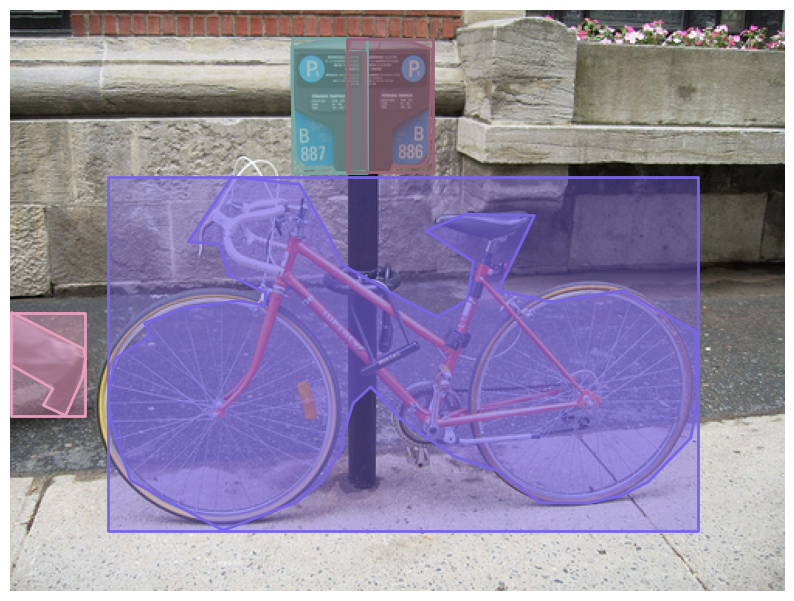

{'license': 1,
 'file_name': '000000370208.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000370208.jpg',
 'height': 375,
 'width': 500,
 'date_captured': '2013-11-14 23:16:53',
 'flickr_url': 'http://farm4.staticflickr.com/3114/2576404641_15ee5d5d25_z.jpg',
 'id': 370208}

Image data: 


In [ ]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


def coco2pil(url):
    print(url)
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


catIds = coco.getCatIds(catNms=["person", "bicycle"])  # get category IDs
# person and bicycle
imgIds = coco.getImgIds(catIds=catIds)
img_list = coco.loadImgs(
    imgIds[12]
)  # http://images.cocodataset.org/val2017/000000370208.jpg
img = img_list[0]

# plot image
plt.figure(figsize=(10, 10))
pil_img = coco2pil(img["coco_url"])
plt.imshow(pil_img)

# plot boundy boxes
annIds = coco.getAnnIds(imgIds=img["id"])
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)
plt.axis("off")
plt.show()
print("Image data: ")
img

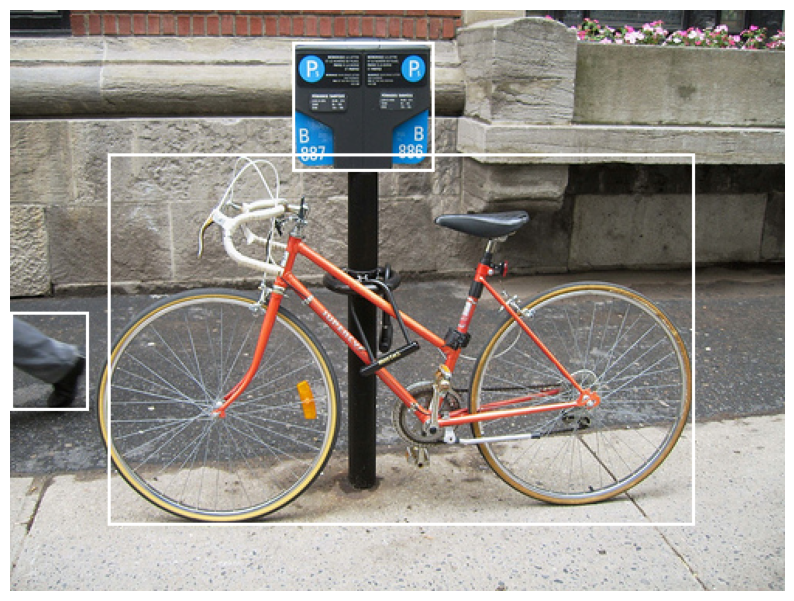

In [ ]:
import torch
import torchvision.transforms.functional as TF
from PIL import ImageDraw


# lets predict objects by resnet50
with torch.no_grad():
    tensor = TF.pil_to_tensor(pil_img) / 255  # Normalize
    output = fr_rcnn_model(tensor.unsqueeze(0))
    draw = ImageDraw.Draw(pil_img)

    # plot rectangles
    for i, bbox in enumerate(output[0]["boxes"]):
        if output[0]["scores"][i] > 0.5:
            draw.rectangle((tuple(bbox[:2].numpy()), tuple(bbox[2:].numpy())), width=2)

    plt.figure(figsize=(10, 10))
    plt.imshow(pil_img)
    plt.axis("off")
    plt.show()

## Region proposal network (RPN)

Как устроена сеть, предсказывающая ROI?

<img src ="https://ml.gan4x4.ru/msu/additions/L11/roi_pooling.png" width="800">

Карта признаков имеет фиксированные и относительно небольшие пространственные размеры (например 20×15). Поэтому можно вернуться к идее скользящего окна, которая была отвергнута в самом начале из-за большого размера изображения.

<img src ="https://ml.gan4x4.ru/msu/additions/L11/rpn_base.png" width="700">

Для карты признаков размером 20×15 количество ROI получится равным 3000, что сравнимо с количеством предсказаний, производимых SelectiveSearch.

Далеко не всегда объект хорошо вписывается в квадрат:

<img src ="https://ml.gan4x4.ru/msu/additions/L11/rpn_aspect_ratio.png" width="900">

Поэтому для каждой точки на карте признаков (anchor) можно использовать окна нескольких форм:

<center><img src ="https://ml.gan4x4.ru/msu/additions/L11/rpn_base_anchor.png" width="700"></center>

<center><em>Source: <a href="https://aman.ai/cs231n/detection/">Detection and Segmentation</a></em></center>

Это позволит минимизировать корректировку* и лучше предсказывать ROI  для вытянутых объектов.

\* *Помним, что для каждого прямоугольника предсказываются 4 числа, обозначающих сдвиг его вершин относительно начального положения.*

Для каждого окна предсказываются два значения:

* вероятность того, что в ROI находится объект (одно число),
* смещения (4 числа).

Сама сеть при этом может быть очень простой:

<img src ="https://ml.gan4x4.ru/msu/additions/L11/simple_nn_predict_objectness_and_boundary_box.png" width="400">

## Two stage detector



Если присмотреться к схеме, можно заметить, что на среднем и верхнем уровнях выполняются схожие операции.

Разница в том, что на последнем слое предсказывается класс объекта, а на промежуточном — только вероятность его присутствия (objectness).

Корректировки для вершин bounding box предсказываются в обоих случаях.

<center><img src ="https://ml.gan4x4.ru/msu/additions/L11/two_stage_detector.png" width="750"></center>

<center><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Detection and Segmentation</a></em></center>

Можно сказать, что детектирование происходит в две стадии.
Соответственно Faster RCNN == Two stage detector

# One Stage detector


Если сразу предсказывать класс, то можно избавиться от второй стадии.
В этом случае к списку классов нужно добавить еще один элемент, который заменит objectness либо будет предсказанием класса "фон".

<img src ="https://ml.gan4x4.ru/msu/additions/L11/one_stage_detector.png" width="800">

Детекторы, которые работают "за один проход", быстрее, но потенциально менее точные.



<center><img src ="https://ml.gan4x4.ru/msu/additions/L11/yolo_ssd_retinanet.png" width="1000"></center>

<center><em>Source: <a href="https://aman.ai/cs231n/detection/">Detection and Segmentation</a></em></center>

Рассмотрим несколько моделей, построенных по этому принципу:
YOLO, SSD, RetinaNet

[Сравнение скорости моделей](https://pytorch.org/vision/stable/models.html#runtime-characteristics)

## SSD: Single Shot MultiBox Detector

<center><img src ="http://edunet.kea.su/repo/EduNet-additions/L11/ssd_default_boxes.png" width="700"></center>

<center><em>Source: <a href="https://ternak.github.io/cnn_detection.html">Object Detection With Convolution Neural Nets</a></em></center>




* Кандидаты в ROI (default box) выбираются на нескольких слоях (4, 7, 8, 9, 11)
* Количество форм окон (default box) на картах признаков зависит от слоя: от 4 до 6

[SSD: Single Shot MultiBox Detector (Liu et al., 2015)](https://arxiv.org/abs/1512.02325)




<center><img src ="http://edunet.kea.su/repo/EduNet-additions/L11/single_shot_multibox_detector_scheme.png" width="1200"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1512.02325.pdf">Single Shot MultiBox Detector</a></em></center>

* В качестве backbone используется VGG-16, предобученная на ImageNet
* Добавлен класс для "background"


В общей сложности делается $8732$ предсказаний, каждое содержит $4 + (N + 1)$ чисел.

$N$ — это количество классов без фона,
$4$ — смещения.


[Подробнее](https://towardsdatascience.com/review-ssd-single-shot-detector-object-detection-851a94607d11)